# DwarfGAN - Deep Learning based Map Design for Dwarf Fortress

### Setup and Imports

In [16]:
""" 

based on example coded provided in Foster, 2019 see:

basic GAN
"G:\Dev\DataScience\GDL_code\models\GAN.py"

Wasserstein GAN
"G:\Dev\DataScience\GDL_code\models\WGAN.py"

Wasserstein GAN with Gradient Penatly
"G:\Dev\DataScience\GDL_code\models\WGANGP.py"

"""
# imports
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.experimental import preprocessing
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.losses import binary_crossentropy

import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import pathlib
import tensorflow as tf
import io
import random

#!pip install boto3
import boto3 as b3 


print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

############### CONFIG ###################

# model name
model_name = 'dwarfgan001'
# folder path to input files (map images)
fpath = r'/data/input'
# folder path to tensorboard output
tboard_dir = '/data/output/tensorboard'
# folder path for saved model output
out_model_dir = '/data/output/models'
# frequency of checkpoint saves (images, model weights) in epochs
checkpoint = 50

##########################################

# NOTE: all extracted map PNGs have been saved on a separate virtual disk mapped to '/data' of the virtual machine in use
data_dir = pathlib.Path(fpath + '/maps')
imgs = list(data_dir.glob('*.png'))

2.3.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### Check available Samples from S3 Bucket

simmler_qualitai_goldstandard_full
storage_hil
Found 119564 images in S3 storage


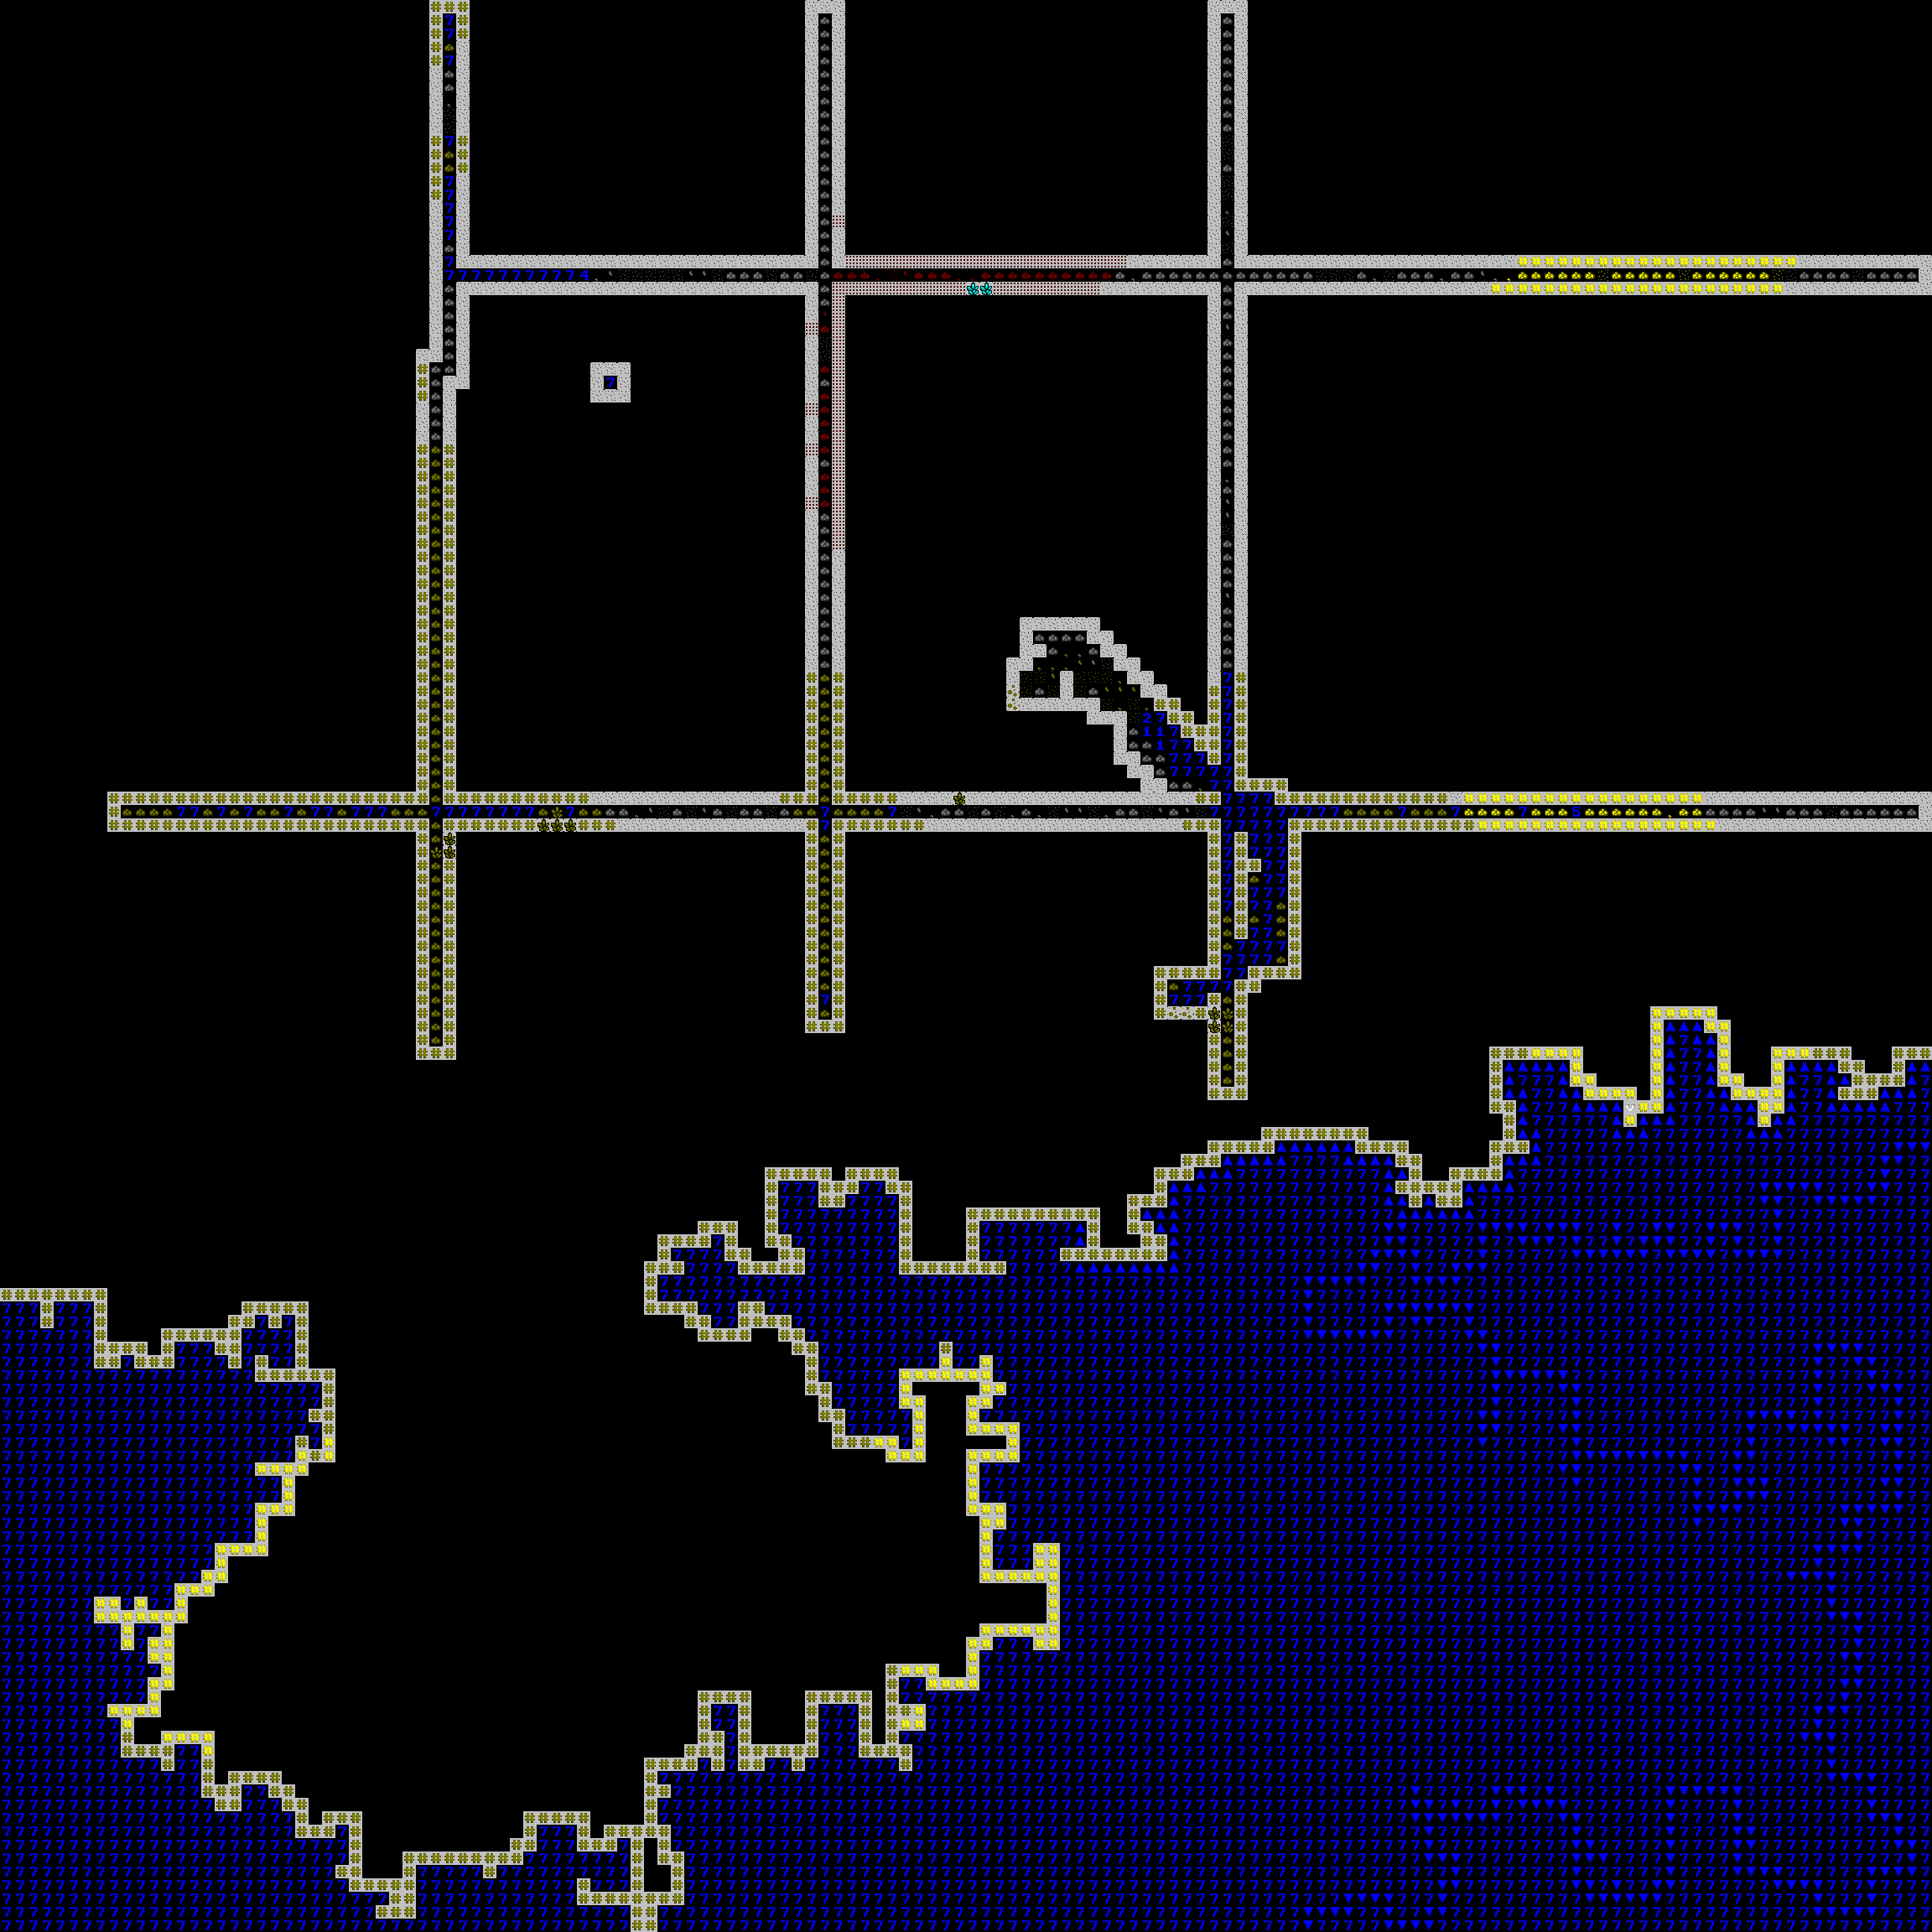

In [4]:
# Load from Switch S3 bucket
s3 = b3.resource('s3',
                 region_name='ZH',
                 endpoint_url='https://os.zhdk.cloud.switch.ch',
                 aws_access_key_id='',    # needs to be specified. Willfully ommited due to security concerns
                 aws_secret_access_key='' # needs to be specified. Willfully ommited due to security concerns
                 )

# check connection
for bucket in s3.buckets.all():
    print(bucket.name)


obj = s3.Object('storage_hil', 'maps/map_1.png')
# get list of files
my_bucket = s3.Bucket('storage_hil')
filelist = [e.key for e in my_bucket.objects.filter(Prefix='maps/')]
print(f'Found {len(filelist)} images in S3 storage')

# get example file from S3 storage and read as Byte stream
img = io.BytesIO(obj.get()['Body'].read())

# Visualize image from S3 bucket
PIL.Image.open(img)

### Data Load and Train / Validation Split

The map images sourced from the DFMA come in a variety of dimensions. In order to create sample images with constant dimensions, as required by tensors, the 100k input samples were run through a python script to randomly crop 10 1024 x 1024 areas per picture. Of those cropped (sub-)images, only the ones which contain structures were retained. This was achieved by filtering out image crops which only contained two or less different colors. With that, the logic mainly filterd out crops which only contained black. This process resulted in 700'000+ (sub-)image samples.

There are 726300 cropped image samples available
A random sample input image:


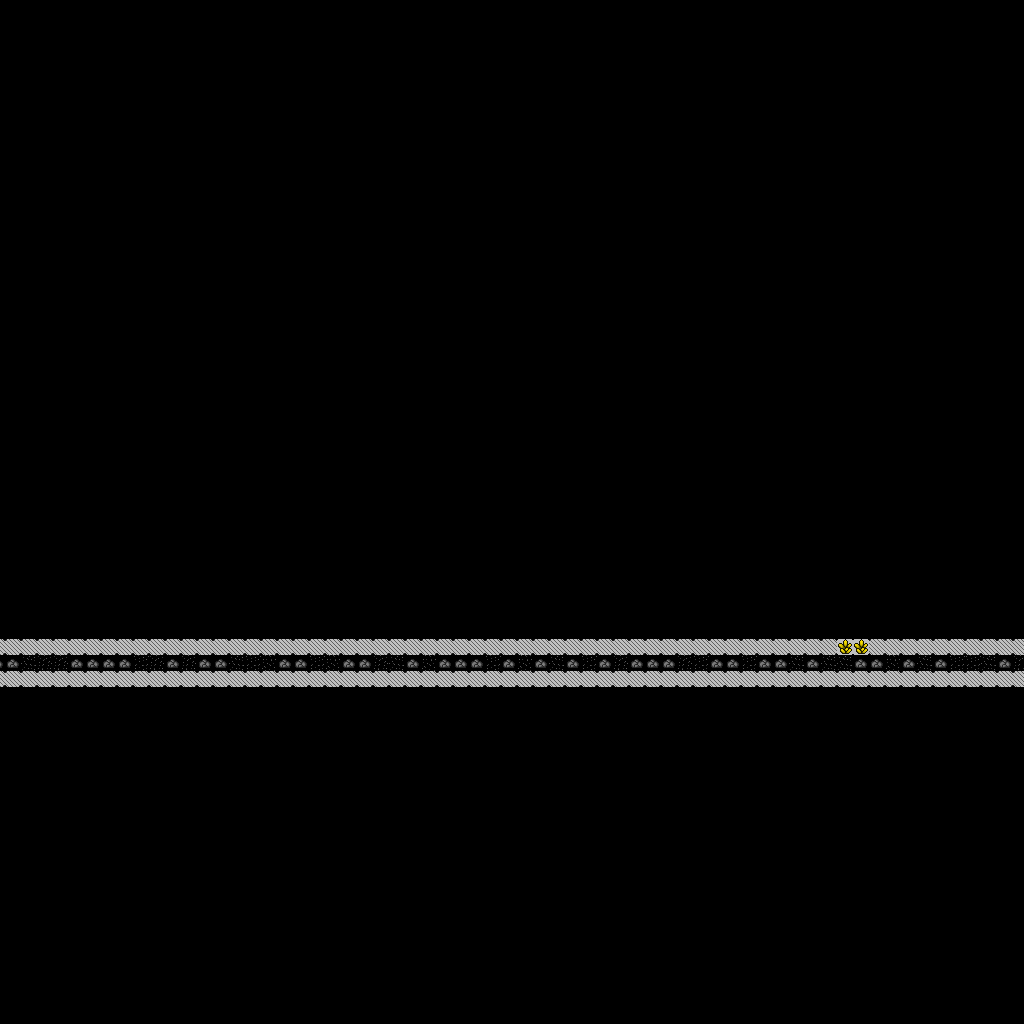

In [18]:
# use pre-processed (cropped) 1024x1024 images
data_dir = pathlib.Path(fpath + '/crops')
imgs = list(data_dir.glob('*.png'))
print(f'There are {str(len(imgs))} cropped image samples available')

# show example sample image (cropped to 1024x1024)
print('A random sample input image:')
PIL.Image.open(imgs[random.randint(0,len(imgs))])

In [23]:
# pre-processed (cropped) images are 1024x1024. We will later resize the images to 512x512 due to memory restrictions.
IMAGE_SIZE = (1024, 1024)
BATCH_SIZE = 32


# creating keras datasets for training and validation - refer to https://www.tensorflow.org/tutorials/images/classification
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(  fpath,
                                                                      image_size=IMAGE_SIZE, 
                                                                      batch_size=BATCH_SIZE, 
                                                                      labels=[1.] * len(imgs), # setting all labels to 1 (for 'real')
                                                                      #label_mode=None, # yields float32 type labels
                                                                      seed=42,
                                                                      validation_split=0.1,
                                                                      subset='training'
                                                                    )

dataset_val = tf.keras.preprocessing.image_dataset_from_directory(  fpath,
                                                                    image_size=IMAGE_SIZE, 
                                                                    batch_size=BATCH_SIZE, 
                                                                    labels=[1.] * len(imgs), # setting all labels to 1 (for 'real')
                                                                    #label_mode=None, # yields float32 type labels
                                                                    seed=42,
                                                                    validation_split=0.1,
                                                                    subset='validation'
                                                                    )


# refer to https://www.tensorflow.org/tutorials/images/classification
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = dataset_train.cache().prefetch(buffer_size=BATCH_SIZE)
val_ds = dataset_val.cache().prefetch(buffer_size=BATCH_SIZE)


ValueError: Expected the lengths of `labels` to match the number of files in the target directory. len(labels) is 726300 while we found 845863 files in /data/input.

### Check Random Sample Dataset

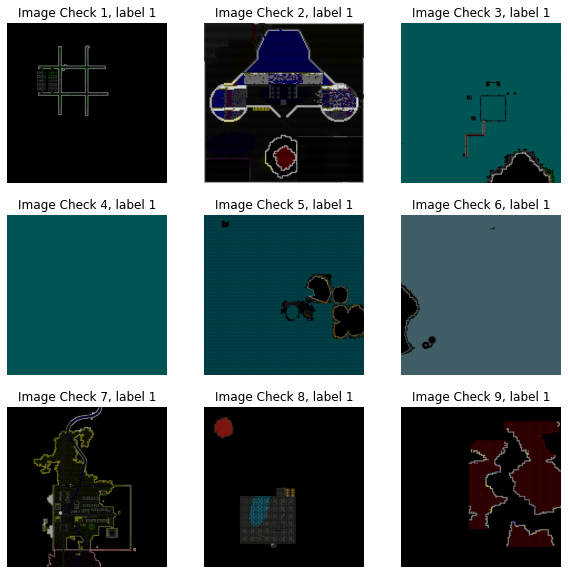

In [3]:
# Check random images from prepared batches
plt.figure(figsize=(10, 10))
for images, labels in dataset_train.take(1): # take one batch. Here batch_size = 32 examples per batch
    for i in range(9): # show first 9 images of batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Image Check {i+1}, label {labels[i]}')
        plt.axis('off')

### Discriminator Model Definition

In [9]:
def discriminator_model():

    # DISCRIMINATOR
    # set input variables to variable width + height. Will be cropped in preprocessing [CURRENTLY FIXED TO 1024x1024]
    input_dim = (None, None, 3)

    # Input
    d_input = Input(shape=input_dim, name='Discriminator_Input')

    # Keras-based preprocessing. Alternative: RandomCrop()
    # use smart_resizing?
    #x = tf.keras.preprocessing.image.smart_resize(d_input, (1024, 1024))
    x = preprocessing.Resizing(width=512, 
                               height=512, 
                               name='Preprocessing_Resize'
                              )(d_input) # Resize to 512 x 512 images

    #x = preprocessing.RandomCrop(height=512, 
    #                            width=512, 
    #                            name = 'Preprocessing_RandomCrop'
    #                           )(d_input)

    x = preprocessing.Rescaling(scale=1./127.5, 
                                offset=-1,
                                name='Preprocessing_Rescale'
                               )(x) # Rescale values from [0,255] to [-1,1] see https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling


    # Conv2D Layer 1
    x = Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = 2,
            padding = 'same',
            name = 'Discriminator_Conv2D_Layer_1'
    )(x)

    # BatchNorm Layer 1
    x = BatchNormalization()(x)

    # Activation 1 - Leaky ReLU
    x = LeakyReLU(alpha = 0.1, name='Activation_1')(x)

    # Dropout 1
    x = Dropout(rate = 0.4)(x)


    # Conv2D Layer 2
    x = Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = 2,
            padding = 'same',
            name = 'Discriminator_Conv2D_Layer_2',
            kernel_initializer = RandomNormal(mean=0., stddev=0.02)
    )(x)

    # BatchNorm Layer 2
    x = BatchNormalization()(x)

    # Activation 2 - Leaky ReLU
    x = LeakyReLU(alpha = 0.1, name='Activation_2')(x)

    # Dropout 2
    x = Dropout(rate = 0.4)(x)


    # Conv2D Layer 3
    x = Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = 2,
            padding = 'same',
            name = 'Discriminator_Conv2D_Layer_3',
            kernel_initializer = RandomNormal(mean=0., stddev=0.02)
    )(x)

    # BatchNorm Layer 3
    x = BatchNormalization()(x)

    # Activation 3 - Leaky ReLU
    x = LeakyReLU(alpha = 0.1, name='Activation_3')(x)

    # Dropout 3
    x = Dropout(rate = 0.4)(x)



    # Conv2D Layer 4
    x = Conv2D(filters = 128,
               kernel_size = 5,
               strides = 2,
               padding = 'same',
               name = 'Discriminator_Conv2D_Layer_4',
               kernel_initializer = RandomNormal(mean=0., stddev=0.02)
    )(x)

    # BatchNorm Layer 4
    x = BatchNormalization()(x)

    # Activation 4 - Leaky ReLU
    x = LeakyReLU(alpha = 0.1, name='Activation_4')(x)

    # Dropout 4
    x = Dropout(rate = 0.4)(x)




    # Conv2D Layer 5
    x = Conv2D(filters = 64,
               kernel_size = 5,
               strides = 2,
               padding = 'same',
               name = 'Discriminator_Conv2D_Layer_5',
               kernel_initializer = RandomNormal(mean=0., stddev=0.02)
    )(x)

    # BatchNorm Layer 5
    x = BatchNormalization()(x)

    # Activation 5 - Leaky ReLU
    x = LeakyReLU(alpha = 0.1, name='Activation_5')(x)

    # Dropout 5
    x = Dropout(rate = 0.4)(x)


    # OUTPUT
    x = Flatten()(x)
    d_output = Dense(1, 
                     activation='sigmoid', 
                     kernel_initializer = RandomNormal(mean=0, stddev=0.02) # random initialization of weights with normal distribution around 0 with small SD
                    )(x)



    # Discriminator Model intialization
    discriminator = Model(d_input, d_output, name='Discriminator')
    
    
    
    return discriminator



### Generator Model Definition

In [10]:
def generator_model():

    # GENERATOR

    # set input variable dimensions. Here we will start out with a vector of length 100 for each sample (sampled from a normal distribution, representing the learned latent space)
    input_dim = (100)

    # Input
    g_input = Input(shape=input_dim, name='Generator_Input')

    # Dense Layer 1
    x = Dense(np.prod([16,16,32]), use_bias=False)(g_input)

    # Batch Norm Layer 1
    x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 1
    x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)

    # Reshape into 3D tensor
    x = Reshape((16,16,32))(x)

    # Upsampling Layer 1 + Conv2D Layer1
    x = UpSampling2D()(x)
    x = Conv2D(filters=64, kernel_size=5, padding='same', name='Generator_Conv_Layer_1')(x)

    # Batch Norm Layer 2
    x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 2
    x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)

    # Upsampling Layer 2 + Conv2D Layer2
    x = UpSampling2D()(x)
    x = Conv2D(filters=128, kernel_size=5, padding='same', name='Generator_Conv_Layer_2')(x)


    # Batch Norm Layer 3
    x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 3
    x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)

    # Upsampling Layer 3 + Conv2D Layer3
    x = UpSampling2D()(x)
    x = Conv2D(filters=64, kernel_size=5, padding='same', name='Generator_Conv_Layer_3')(x)


    # Batch Norm Layer 4
    x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 4
    x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)

    # Upsampling Layer 4 + Conv2D Layer4
    x = UpSampling2D()(x)
    x = Conv2D(filters=64, kernel_size=5, padding='same', name='Generator_Conv_Layer_4')(x)


    # Batch Norm Layer 5
    x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 5
    x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)



    # Upsampling Layer 5 + Conv2D Layer5
    x = UpSampling2D()(x)
    x = Conv2D(filters=32, kernel_size=5, padding='same', name='Generator_Conv_Layer_5')(x)


    # Batch Norm Layer 6
    x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 6
    x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)

    # REMOVED FOR 512x512 PICS
    # ---------------------------
    # Upsampling Layer 7 + Conv2D Layer7
    x = UpSampling2D()(x)
    x = Conv2D(filters=32, kernel_size=5, padding='same', name='Generator_Conv_Layer_6')(x)


    # Batch Norm Layer 7
    x = BatchNormalization(momentum = 0.9)(x)

    # Activation Layer 7
    x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)


    # Upsampling Layer 8 + Conv2D Layer8
    x = Conv2D(filters=3, kernel_size=5, padding='same', name='Generator_Conv_Layer_7')(x)
    # ---------------------------/
    
    # tanh activation layer to scale values to [-1:1]
    x = Activation('tanh')(x)

    # Output
    g_output = x


    # Generator Model initialization
    generator = Model(g_input, g_output, name='Generator')
    
    
    return generator


### GAN (Full) Model Compilation

In [11]:
# Definition of KERAS strategy for distributed training (single host, multi GPU strategy = Mirrored). See: https://keras.io/guides/distributed_training/
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

   
    discriminator = discriminator_model()
    generator = generator_model()
        
    
    # COMPILATION
    discriminator.compile(optimizer=Adam(lr=0.0008), # per Foster, 2017 RMSprop(lr=0.0008)
                          loss=binary_crossentropy,
                          metrics=['accuracy']) 

    # to train the generator as part of the full GAN, we have to freeze the discriminator weights
    discriminator.trainable = False

    model_input = Input(shape=(100), name='GAN_input')
    # Output of generator is connected to the discriminator here
    model_output = discriminator(generator(model_input))

    # The complete GAN model
    gan = Model(model_input, model_output)

    gan.compile(optimizer=RMSprop(lr=0.0004), # here we try RMSprop instead of ADAM with a learning rate of 0.0004 (< than discriminator lr as the discriminator should be stronger than the generator)
                loss=binary_crossentropy, 
                metrics=['accuracy'])





INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [24]:
generator.summary()
discriminator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator_Input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_9 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_52 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 16, 16, 32)        0         
_________________________________________________________________
up_sampling2d_23 (UpSampling (None, 32, 32, 32)        0         
_________________________________________________________________
Generator_Conv_Layer_1 (Conv (None, 32, 32, 64)        51

### Training Definition

In [12]:
def train_discriminator(x_train, batch_size, step, tensorboard):
    '''
    Train Discriminator on real and fake images
    '''
    tensorboard.set_model(discriminator)
    
    #make sure discriminator is trainable
    discriminator.trainable = True
    
    #iterate over pre-made batches
    for images, labels in x_train.take(1):
        #Real Images
        labels += 0.05 * tf.random.uniform(labels.shape) #IMPORTANT TRICK: introduce slight randomness to labels to prevent GAN from getting stuck in training
        discriminator.train_on_batch(images, labels)

        #Generated Images
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise) # random generated images of (untrained) generator
        labels = np.zeros((batch_size, 1))
        labels += 0.05 * tf.random.uniform(labels.shape) #IMPORTANT TRICK: introduce slight randomness to labels to prevent GAN from getting stuck in training
        history = discriminator.train_on_batch(gen_imgs, labels) 
        
    #write out to tensorboard after 1 epoch
    batch_id = step
    tensorboard.on_epoch_end(batch_id, named_logs(discriminator, history))
    
    
def train_generator(batch_size, step, tensorboard):
    '''
    Train Generator on random generated 100 dimensional input vector
    '''
    tensorboard.set_model(gan)
    
    #make sure the discriminator is NOT trainable for the generator/full GAN training
    discriminator.trainable = False
    
    #train generator/GAN
    noise = np.random.normal(0, 1, (batch_size, 100))
    history = gan.train_on_batch(noise, np.zeros((batch_size,1)))
    
    #write out to tensorboard
    batch_id = step
    tensorboard.on_epoch_end(batch_id, named_logs(gan, history))
    
    
def train_gan(disc_train, epoches, batch_size, interval):
    '''
    Train the complete GAN by iterating over the number of epoches
    and alternate between training the discriminator and generator
    '''

    # Tensorboard config
    now = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')

    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir = f'{tboard_dir}/{model_name}_{now}', 
        write_graph = True,
        write_images = True,
        histogram_freq = 1)        
    

    for i in range(epoches):
        print(f"[{10*'-'}] GAN Epoch {i+1} started [{10*'-'}]")

        # !!! Add another for loop here over step, image in enumerate(dataset) see https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch  (at the bottom, last code block)
        train_discriminator(disc_train, batch_size, i, tensorboard)
        train_generator(batch_size, i, tensorboard)
        
        # for defined interval take snapshots of generator output and save model
        if (i+1) % interval == 0:
            # take sample output images from generator
            sample_img(i)

            # save corresponding model
            gan.save(f'{out_model_dir}/full-gan-{now}')
            generator.save(f'{out_model_dir}/generator-{now}')        

            
# Transform train_on_batch return value
# to dict expected by on_batch_end callback
def named_logs(model, logs):
    result = {}
    for l in zip(model.metrics_names, logs):
        result[l[0]] = l[1]
    return result
        
   
     
# ---------------> CHECK IMPLEMENTATION <-------------------        
def sample_img(epoch):
    noise = np.random.normal(0, 1, (10, 100))
    gen_imgs = generator.predict(noise)
    
    gen_imgs = 0.5 * (gen_imgs + 1)  #scale back to [0:1]
    gen_imgs = gen_imgs.reshape((10, 1024, 1024, 3))
    
    # save 10 example images
    for i in range(10):
        fig = plt.figure(figsize=(20, 20))
        plt.imshow(gen_imgs[i])
        plt.title(f'Example Generator Output')
        plt.axis('off')
        
        # adjust path based on whether execution is local or on linux VM
        fig.savefig(f'/data/output/images/{model_name}/sample_image_epoch{epoch+1}-{i+1}.png')
        plt.close()
    



### Training (over x Epochs)

In [ ]:
# Train GAN
train_gan(train_ds, 5000, BATCH_SIZE, checkpoint)

[----------] GAN Epoch 1 started [----------]
[----------] GAN Epoch 2 started [----------]
[----------] GAN Epoch 3 started [----------]
[----------] GAN Epoch 4 started [----------]
[----------] GAN Epoch 5 started [----------]
[----------] GAN Epoch 6 started [----------]
[----------] GAN Epoch 7 started [----------]
[----------] GAN Epoch 8 started [----------]
[----------] GAN Epoch 9 started [----------]
[----------] GAN Epoch 10 started [----------]
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /data/output/models/full-gan-2021-03-04_093146/assets
INFO:tensorflow:Assets written to: /data/output/models/generator-2021-03-04_093146/assets
[----------] GAN Epoch 11 started [----------]
[----------] GAN Epoch 12 started [----------]
[----------] GAN Epoch 13 starte

In [19]:
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator_Input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_29 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 32)        0         
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 32, 32, 32)        0         
_________________________________________________________________
Generator_Conv_Layer_1 (Conv (None, 32, 32, 64)        51

### Generate Examples using learned Generator Model

(-0.5, 1023.5, 1023.5, -0.5)

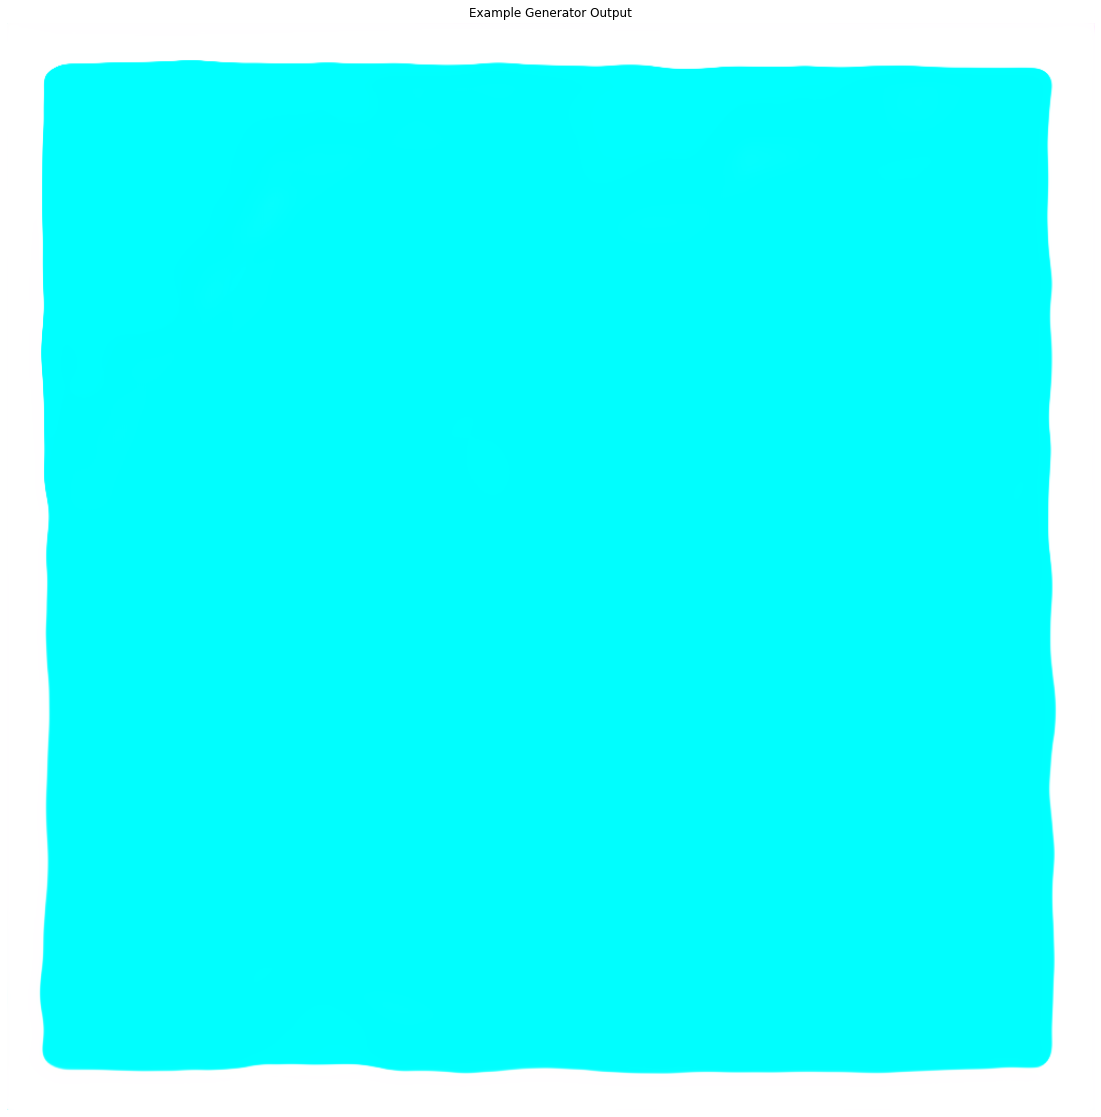

In [18]:
# load generator

generator.compile(optimizer=Adam(lr=0.0008), # per Foster, 2017 RMSprop(lr=0.0008)
                          loss=binary_crossentropy,
                          metrics=['accuracy'])
generator = tf.keras.models.load_model('/data/output/models/generator-2021-03-04_093146')

# generate new example of learned representation in latent space
noise = np.random.normal(0, 1, (1, 100))
res = generator.predict(noise)

# reinstate scale of pixel values to [0:1] and reshape
res = 0.5 * (res + 1)
res = res.reshape((1024, 1024, 3))

# Visualize result
plt.figure(figsize=(20, 20))
plt.imshow(res)
plt.title(f'Example Generator Output')
plt.axis('off')

# TODOs

### Changes made after 10 epoche run (V0.0)
---
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-02-512.png" width=20></img> kernel initializer in discriminator Conv2D layers set to RandomNormal(mean=0., stddev=0.02) (before default value = glorot_uniform aka Xavier)

### Changes to be made after 100 epoche run (for V0.5)
---
- Batch size 32 --> 64. Potentially use increasing batch size (rather than decay of learning rate) see: https://stackoverflow.com/questions/50606995/how-to-change-the-batch-size-during-training  --> might lead to memory problems in current 44GB RAM VM
- Dynamically increase batch size instead of decaying learning rate to accelarate training see https://arxiv.org/abs/1711.00489
- check some filters on different Conv2D layers --> use smaller filter to detect relatively small features?
- adjust filter size for some layers (5x5 -> 10x10?) --> shrinking size too fast is not helpful. maybe add additional conv layers to shrink more slowely?
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-02-512.png" width=20></img> Discriminator Optimizer Adam -> RMSprop
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-02-512.png" width=20></img> Added discriminator.trainable = True/False flags to training functions for discriminator/generator (GAN) to ensure discriminator is actually trainable
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-02-512.png" width=20></img> So far only 3652 images were used for training (single image maps and map archives starting with X, Y or Z). The next training cycle will include maps starting with U, V or W --> added all available samples
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-14-512.png" width=20></img> add 'sample_img()' function to execute every 'sample_interval' - added but not tested
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-14-512.png" width=20></img> tune polarization method in input data pipeline which scales pictures to 1024 x 1024? OR randomly crop a 1024 x 1024 piece of the input image to better preserve size of objects rather than scaling everything to 1024x1024 ==> random crop changed to 512x512 due to OOM error in training on GPUs
==> pre-processing applied to input 100k input images of different size: random cropped 10 1024x1024 regions and dropping all black etc. images, generating over 700k cropped samples
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-02-512.png" width=20></img> implement tensorboard for model monitoring during training
- try zero centering (mean subtracting) input data?
- use Randomized ReLU instead of leaky see: https://arxiv.org/pdf/1505.00853.pdf
- add another loop in train_gan() over different steps within training loop?
- <img src="https://cdn1.iconfinder.com/data/icons/warnings-and-dangers/400/Warning-02-512.png" width=20></img> add slight randomness to labels (see Chollet p. 307)
- implement wasserstein GAN with gradient penalty (WGAN-GP, see  Foster p. 115 ff)
- use Frechet Inception Distance (FIP) for evaluation of GAN performance (see https://arxiv.org/abs/1706.08500 )

# Notes - Besprechung Vorstudie 15.01.2021

- Ausdrücke aus der Game Welt evtl. näher erläutern erläutern bspw. "Game Assets"
- Spezifizierung Forschungsfragen --> Ziele etwas zu offen bspw. was heisst "sufficiently able to learn" --> include Frechet Inception Distance (FIP)
    -- konkretisieren
    -- 2 Milestones (konkret) formulieren für Ergebnis mit Termin pro Milestones für Vorstellung dieser Milestones (mit Thomas Koller im CC inkl. Vorstudie) --> Für Herrn Birbaumer am liebsten <b>Donnerstag Nachmittag</b>:
        --- Milestone 1: Frechet Distance für ersten milestone 1 + WGAN-GP? Einführung nochmals Vorstudie als überblick
        --- Milestone 2: ???
- Bewertung von Games / Vergleichsstudie --> wie können Game Devs dazu bewogen werden diese zu verwenden, was sind das für Kriterien
- 2-3 Wochen vor Abgabe "Abschlusspresentation" einplanen